In [62]:
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch.nn as nn
import torch_geometric.nn as geom_nn
import copy
from torch.optim.lr_scheduler import  ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import pickle
import math

import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.dense import DenseGCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [67]:
### Load the list from the pickle file ###
### Train Data ###
loc = "simple_connections_data/temporal_split/"
# experiment = "rho2_30percent_Re300/data_inputs_with_drag_minmax_scaler/"
experiment = "rho2_30percent_Re300/"

### Train Inputs ###
with open(loc+experiment+'train_data_np_scaled.pkl', 'rb') as f:
    train_data_np_scaled = pickle.load(f)

### Test Inputs ###
with open(loc+experiment+'test_data_np_scaled.pkl', 'rb') as f:
    test_data_np_scaled = pickle.load(f)
        
### Train Outputs ###
train_output = np.load(loc+experiment+"train_output_scaled.npy")

### Test Outputs ###
test_output = np.load(loc+experiment+"test_output_scaled.npy")

# Combined_model

In [68]:
def make_batch_index_tensor(node_length, batch_size):
    # Create a tensor containing values from 0 to batch_size - 1
    values = torch.arange(batch_size)
    # Repeat each value node_length times and flatten the result
    repeated_values = values.repeat_interleave(node_length)
    return repeated_values

In [69]:
def make_edge_index_tensor(batch_size):
    
    edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                               [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
    
    if batch_size==1:
    
        return edge_index
    
    if batch_size>1:
        
        add = torch.cat([ torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]) + 16*(i+1) for i in range(batch_size-1)],axis=1)
        
        edge_index_expanded = torch.cat((edge_index,add),axis=1)
    
        return edge_index_expanded

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_add_pool as gap

class GNN_with_attention(nn.Module):
    
    def __init__(self, num_gcn_layers=2, gcn_embedding_size=64, 
                 num_nodes=16, num_features=4, dropout_prob=0.20, heads=2):
        
        super(GNN_with_attention, self).__init__()
        torch.manual_seed(42)

        self.num_gcn_layers = num_gcn_layers
        self.gcn_embedding_size = gcn_embedding_size
        self.num_nodes = num_nodes
        self.num_features = num_features
        self.heads = heads
        self.dropout_prob = dropout_prob

        self.initial_conv = GATv2Conv(self.num_features, self.gcn_embedding_size, self.heads)
        
        self.convs = nn.ModuleList([GATv2Conv(self.gcn_embedding_size * self.heads, self.gcn_embedding_size, self.heads) 
                                    for _ in range(self.num_gcn_layers - 1)])

        self.dropout = nn.Dropout(p=self.dropout_prob)

    def forward(self, x, edge_index, x_scalar, batch_index):
      
        hidden = F.leaky_relu(self.initial_conv(x, edge_index))
      
        for i, conv in enumerate(self.convs):
            hidden = F.leaky_relu(conv(hidden, edge_index))
            if i % 2 == 1:
                hidden = self.dropout(hidden)

        hidden = gap(hidden, batch_index)
        hidden = torch.cat((hidden, x_scalar), axis=1)

        return hidden

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TimeSeriesTransformerEncoder(nn.Module):
    
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, max_len):
        super(TimeSeriesTransformerEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward
        self.max_len = max_len
        
        self.input_projection = nn.Linear(self.input_dim, self.d_model)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_len)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead
                                                  ,dim_feedforward=self.dim_feedforward)
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.output_projection = nn.Linear(self.d_model, 1)

    def forward(self, x):

        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)
        x = self.positional_encoding(x)  # (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x)  # (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)
        x = x.transpose(1, 2)  # (batch_size, d_model, seq_len)
        x = self.pooling(x)  # (batch_size, d_model, 1)
        x = x.squeeze(2)  # (batch_size, d_model)
        x = self.output_projection(x)  # (batch_size, 1)
        
        return x

class GNN_Transformer(nn.Module):
    
    def __init__(self, num_gcn_layers=2, gcn_embedding_size=128, 
                 num_nodes=16, num_features=4, dropout_prob=0.2, heads=2,  ### GAT parameters
                 input_dim=260, d_model=124, nhead=4, num_layers=2, dim_feedforward=64, max_len=5):  ### Transformer parameters
        super(GNN_Transformer, self).__init__()
        
        self.num_gcn_layers = num_gcn_layers 
        self.gcn_embedding_size = gcn_embedding_size 
        self.num_nodes=num_nodes
        self.num_features=num_features 
        self.dropout_prob=dropout_prob 
        self.heads=heads  ### GAT parameters
        
        self.input_dim=input_dim 
        self.d_model=d_model 
        self.nhead=nhead 
        self.num_layers=num_layers 
        self.dim_feedforward=dim_feedforward 
        self.max_len=max_len ### Transformer parameters
        
        self.GNN = GNN_with_attention(self.num_gcn_layers,  self.gcn_embedding_size,
                                       self.num_nodes, self.num_features, 
                                      self.dropout_prob, self.heads)
        
        self.transformer = TimeSeriesTransformerEncoder(self.input_dim, self.d_model, 
                                                        self.nhead,self.num_layers, self.dim_feedforward, max_len)

    def forward(self, x, x_scalar):
        
        # x shape: (batch_size, seq_len, num_nodes, num_features) # try combinignthe seq_len and num_features 
        # edge_index, x_scalar, and batch_index should be provided for each graph in the sequence
        
        batch_size, seq_len, num_nodes, num_features = x.size()
        gnn_embeddings = []
        
        for i in range(seq_len):
            
            x_t = x[:, i, :, :].reshape(-1,num_features)  # shape: (batch_size * num_nodes, num_features)
            
            edge_index_t = make_edge_index_tensor(batch_size).cuda() # Assuming edge_index is the same for all graphs in the sequence

            x_scalar_t = x_scalar[:, i, :]  # shape: (batch_size, scalar_features)

            batch_index_t = make_batch_index_tensor(num_nodes,batch_size).cuda()  # shape: (batch_size * num_nodes,)

            gnn_embedding_t = self.GNN(x_t, edge_index_t, x_scalar_t, batch_index_t)
            gnn_embeddings.append(gnn_embedding_t.unsqueeze(1))  # Add sequence dimension

        gnn_embeddings = torch.cat(gnn_embeddings, dim=1)  # shape: (batch_size, seq_len, gnn_embedding_size)
        prediction = self.transformer(gnn_embeddings)
        
        return prediction

In [105]:
model = GNN_Transformer(num_gcn_layers=2, gcn_embedding_size=128, 
                        num_nodes=16, num_features=4, dropout_prob=0.2, heads=2,  
                        input_dim=259, d_model=124, nhead=4, num_layers=2, dim_feedforward=64, max_len=6).cuda()

### with drag input dim should be 260 , without drag input dim should be 259 ###

trial_input = torch.randn(16,6,16,4).cuda()
trial_scalar = torch.randn(16,6,3).cuda()

model(trial_input,trial_scalar).shape

torch.Size([16, 1])

In [106]:
gat_conv = GATv2Conv(in_channels=4,out_channels=16,heads=5)
trial_input = torch.randn(16,4)
edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
gat_conv(trial_input,edge_index).shape

torch.Size([16, 80])

In [107]:
gnn_layers = GNN_with_attention(num_gcn_layers=2, gcn_embedding_size=64, 
                   num_nodes=16, num_features=4, dropout_prob=0.20, heads=2)

trial_input = torch.randn(16,4)
trial_edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])

trial_scalar = torch.randn(1,4)
trial_batch_index  =  torch.zeros(16, dtype=torch.int64)

trial_output = gnn_layers( x=trial_input, 
                           edge_index=trial_edge_index,
                           x_scalar=trial_scalar,
                           batch_index=trial_batch_index)
trial_output.shape

torch.Size([1, 132])

In [136]:
### nodal data ###
nodal_inputs_train = torch.stack([ torch.tensor(train_data_np_scaled[i][:,0:64].reshape(6,16,4)) for i in range(len(train_data_np_scaled))])
nodal_inputs_test = torch.stack([ torch.tensor(test_data_np_scaled[i][:,0:64].reshape(6,16,4)) for i in range(len(test_data_np_scaled))])

### edge connections ###
edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])

### global scalar inputs ### 
global_inputs_train = torch.stack([ torch.tensor(train_data_np_scaled[i][:,64:68]) for i in range(len(train_data_np_scaled))])
global_inputs_test = torch.stack([ torch.tensor(test_data_np_scaled[i][:,64:68]) for i in range(len(test_data_np_scaled))])

### Targets ###
outputs_train = torch.stack([ torch.tensor(train_output[i])[None,None] for i in range(len(train_output))])
outputs_test = torch.stack([ torch.tensor(test_output[i])[None,None] for i in range(len(test_output))])

In [109]:
### Geometric Dataloader ###
from torch_geometric.loader import DataLoader

train_combined = list()
test_combined = list()

from torch_geometric.loader import DataLoader

### Stacking up train data ###
for i in range(len(nodal_inputs_train)):

    ### reading the nodal inputs ###
    x = nodal_inputs_train[i].float().clone().detach()
    
    ### adding drag force as y ###
    y = outputs_train[i].float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    train_combined.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y.clone().detach()))
    
### Stacking up test data ###
for i in range(len(nodal_inputs_test)):

    ### reading the nodal inputs ###
    x = nodal_inputs_test[i].float().clone().detach()
    
    ### adding drag force as y ###
    y = outputs_test[i].float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    test_combined.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y.clone().detach()))
    
### Wrap data in a data loader ###
NUM_GRAPHS_PER_BATCH = 10

train_loader = DataLoader(list(zip(train_combined,global_inputs_train)), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

test_loader = DataLoader(list(zip(test_combined,global_inputs_test)), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [110]:
for batch,inputs_global in train_loader:
    
    print(batch.x.shape)
    print(batch.batch)
    
    break

torch.Size([60, 16, 4])
tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9])


In [111]:
### Basic Dataloader ###
from torch.utils.data import Dataset, DataLoader 

NUM_GRAPHS_PER_BATCH=16
N_train = -1
N_test = -1


# train_loader = DataLoader(list(zip(nodal_inputs_train,global_inputs_train,outputs_train)), 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

# test_loader = DataLoader(list(zip(nodal_inputs_test,global_inputs_test,outputs_test)), 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

train_loader = DataLoader(list(zip(nodal_inputs_train,global_inputs_train,torch.tensor(train_output) )), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

test_loader = DataLoader(list(zip(nodal_inputs_test,global_inputs_test,torch.tensor(test_output))), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [112]:
for nodal,scalar,target in train_loader:
    
    break
    
print(nodal.shape)
print(scalar.shape)
print(target.shape)

torch.Size([16, 6, 16, 4])
torch.Size([16, 6, 5])
torch.Size([16, 1])


# Run Training

In [124]:
model = GNN_Transformer(num_gcn_layers=2, gcn_embedding_size=128, 
                        num_nodes=16, num_features=4, dropout_prob=0.2, heads=2,  
                        input_dim=260, d_model=124, nhead=4, num_layers=2, dim_feedforward=64, max_len=6).float().cuda()

# model(nodal.to(torch.float32).cuda(),scalar.to(torch.float32).cuda()).shape
# print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [125]:
# from torch_geometric.data import DataLoader
# import warnings
# warnings.filterwarnings("ignore")

# # Root mean squared error
# loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)  

# # Use GPU for training
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# ### lr scheduler ###
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, verbose=True)

# epoch_loss_train = list()
# epoch_loss_val = list()
# lr_list = list()

# for epoch in range(0,200):
#     print(f'Starting Epoch {epoch+1}')

#     loss_train = list()
#     loss_val = list()
    
#     for nodal,scalar,targets in train_loader:

#         nodal = nodal.to(torch.float32).cuda()
#         scalar = scalar.to(torch.float32).cuda()
#         targets = targets.to(torch.float32).cuda()

#         optimizer.zero_grad()

#         pred = model(nodal,scalar)
        
#         loss = loss_fn(pred, targets[:,None])

#         loss.backward()  
        
#         # Update using the gradients
#         optimizer.step()   

#         loss_train.append(loss.item())

#     for nodal,scalar,targets in test_loader:

#         nodal = nodal.to(torch.float32).cuda()
#         scalar = scalar.to(torch.float32).cuda()
#         targets = targets.to(torch.float32).cuda()
# #         print("nodal and scalar shape",nodal.shape,scalar.shape)
#         pred = model(nodal,scalar)
# #         print("pred and targets shape",pred.shape, targets.shape)
#         loss = loss_fn(pred, targets[:,None])
#         loss_val.append(loss.item())
        
#     print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
#     print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

#     epoch_loss_train.append(np.array(loss_train).mean())
#     epoch_loss_val.append(np.array(loss_val).mean())

#     ### applying lr scheduling ###
#     lr_list.append(optimizer.param_groups[0]['lr'])
#     scheduler.step(epoch_loss_train[-1])

#     if epoch%5==0:
        
#         torch.save(model.state_dict(), "simple_connections_data/temporal_split/"+experiment+"/model_"+str(epoch))

#     np.save("simple_connections_data/temporal_split/"+experiment+"/epoch_loss_train",epoch_loss_train)
#     np.save("simple_connections_data/temporal_split/"+experiment+"/epoch_loss_test",epoch_loss_val)

# print("Training has completed")

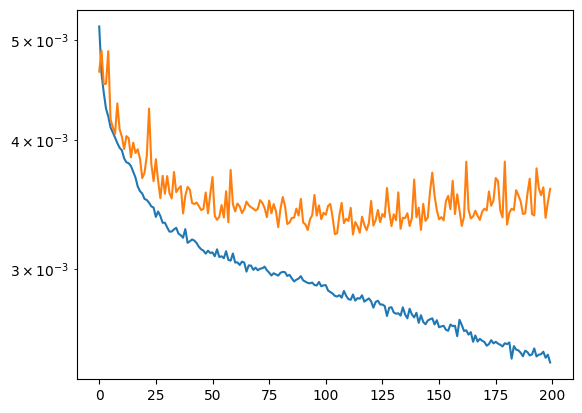

In [126]:
train_unsteady = np.load("simple_connections_data/temporal_split/rho2_30percent_Re300/epoch_loss_train.npy")
test_unsteady = np.load("simple_connections_data/temporal_split/rho2_30percent_Re300/epoch_loss_test.npy")

plt.semilogy(train_unsteady)
plt.semilogy(test_unsteady)

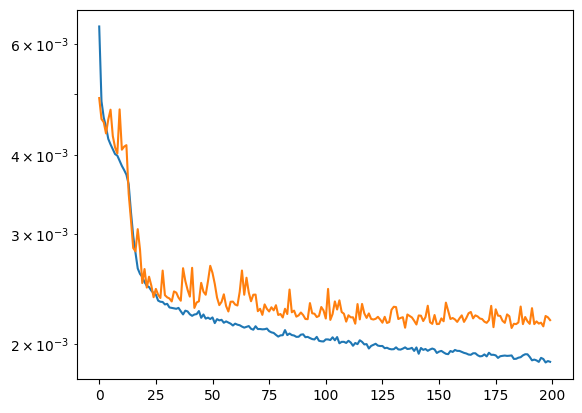

In [127]:
train_unsteady = np.load("simple_connections_data/temporal_split/rho2_30percent_Re300/data_inputs_with_drag_minmax_scaler/epoch_loss_train.npy")
test_unsteady = np.load("simple_connections_data/temporal_split/rho2_30percent_Re300/data_inputs_with_drag_minmax_scaler/epoch_loss_test.npy")

plt.semilogy(train_unsteady)
plt.semilogy(test_unsteady)

In [138]:
### Load the model ###
# model.load_state_dict(torch.load( "simple_connections_data/temporal_split/rho2_30percent_Re300/data_inputs_with_drag_minmax_scaler/model_90"))
model.load_state_dict(torch.load( "simple_connections_data/temporal_split/rho2_30percent_Re300/model_100"))

model = model.cuda()

In [140]:
test_loader = DataLoader(list(zip(nodal_inputs_test,global_inputs_test,outputs_test)), 
                    batch_size=1, shuffle=False)

k=0

pred = list()
gt = list()

model.eval()
for nodal,scalar,targets in test_loader:
    
    print("Data point number",str(k+1))
    nodal = nodal.to(torch.float32).cuda()
    scalar = scalar.to(torch.float32).cuda()
    targets = targets.to(torch.float32).cuda()
        
    pred.append(model(nodal,scalar))
    gt.append(targets)
    
    k=k+1
    clear_output(wait=True)

Data point number 2135



KeyboardInterrupt



In [ ]:
plt.figure(figsize=(10,5))

plt.scatter(torch.stack(gt).detach().cpu().numpy()[:,0,0,0],
           torch.stack(pred).detach().cpu().numpy()[:,0,0],alpha=0.2,
            c=np.arange(len(gt)))

print(r2_score( torch.stack(gt).detach().cpu().numpy()[:,0,0] , torch.stack(pred).detach().cpu().numpy()[:,0] ) )

plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))

In [19]:
gt_numpy = torch.stack(gt).detach().cpu().numpy()[:,0,0,0]
pred_numpy = torch.stack(pred).detach().cpu().numpy()[:,0,0]

gt_numpy = np.array(110.135844 - (-103.509113))*(gt_numpy) + (-103.509113)
pred_numpy = np.array(110.135844 - (-103.509113))*(pred_numpy) + (-103.509113)

rel_err = np.abs(gt_numpy-pred_numpy)/np.abs(gt_numpy)
print(rel_err.mean())

0.2946908


0.6476857703925896


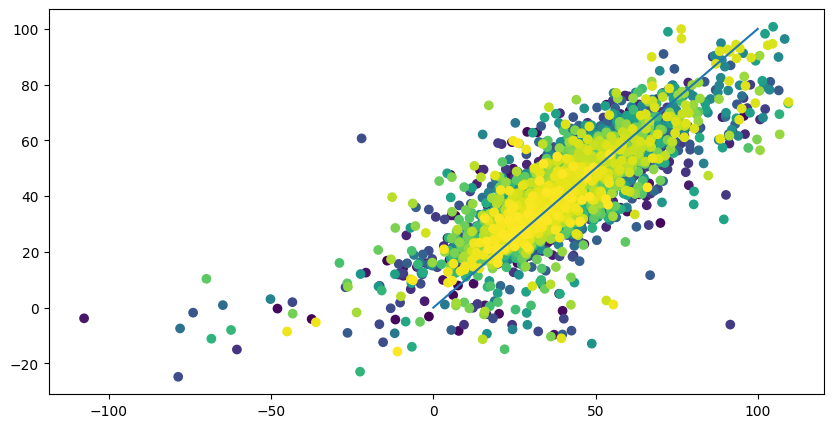

In [20]:
plt.figure(figsize=(10,5))

plt.scatter(gt_numpy,
           pred_numpy,
            c=np.arange(len(gt_numpy)))

print(r2_score( gt_numpy , pred_numpy ) )

plt.plot(np.linspace(0,100,10),np.linspace(0,100,10))

In [21]:
pd.DataFrame( np.concatenate( (gt_numpy[:,None],pred_numpy[:,None],rel_err[:,None]),axis=1)
             ,columns=["GT Drag","Pred Drag","Rel Err"]).to_csv("/home/neilashwinraj/gnns/volatile/attention_GNN_with_transformers")

# Recurrent predictions

In [57]:
### Without recurrent feedback ###
test_dataset_identifiers = pd.read_csv("/home/neilashwinraj/gnns/volatile/test_dataset_identifiers")
test_dataset_identifiers_np = np.load("/home/neilashwinraj/gnns/volatile/test_dataset_identifiers_np.npy")

### Selecting the particles ###
### first index is the case and second is the particle ID ##
case_no = 1
particle_number = 3
idx = np.where((test_dataset_identifiers_np[:,:,0]==case_no)&
         (test_dataset_identifiers_np[:,:,1]==particle_number))[0]
idx = np.unique(idx)

nodal_inputs_test_single_particle = nodal_inputs_test[idx].clone()
global_inputs_test_single_particle =global_inputs_test[idx].clone()
outputs_test_single_particle = outputs_test[idx].clone()

pred_new = list()
gt_new = list()

model.eval()

### getting the predictions ###
for i in range(len(nodal_inputs_test_single_particle)):
    
    print("Currently at (case,particle ID,time) : ",test_dataset_identifiers_np[idx][i][-1])
    
    nodal = nodal_inputs_test_single_particle[i].to(torch.float32).cuda()[None,:]
    scalar = global_inputs_test_single_particle[i].to(torch.float32).cuda()[None,:]
    targets = outputs_test_single_particle[i].to(torch.float32).cuda()[None,:]
           
    pred_new.append(model(nodal,scalar)[0,0].detach().cpu().numpy())
    gt_new.append(targets[0,0,0].detach().cpu().numpy())
        
    clear_output(wait=True)    
    
pred_new = np.stack(pred_new)
gt_new = np.stack(gt_new)

Currently at (case,particle ID,time) :  [  1.   3. 151.]


In [58]:
test_dataset_identifiers = pd.read_csv("/home/neilashwinraj/gnns/volatile/test_dataset_identifiers")
test_dataset_identifiers_np = np.load("/home/neilashwinraj/gnns/volatile/test_dataset_identifiers_np.npy")

### Selecting the particles ###
### first index is the case and second is the particle ID ##
idx = np.where((test_dataset_identifiers_np[:,:,0]==case_no)&
         (test_dataset_identifiers_np[:,:,1]==particle_number))[0]
idx = np.unique(idx)

nodal_inputs_test_single_particle = nodal_inputs_test[idx].clone()
global_inputs_test_single_particle = global_inputs_test[idx].clone()
outputs_test_single_particle = outputs_test[idx].clone()

pred = list()
gt = list()

### Predicted Recurrence predictions ###
for i in range(len(nodal_inputs_test_single_particle)):
    
    print("Currently at (case,particle ID,time) : ",test_dataset_identifiers_np[idx][i][-1])
    
    nodal = nodal_inputs_test_single_particle[i].to(torch.float32).cuda()[None,:]
    scalar = global_inputs_test_single_particle[i].to(torch.float32).cuda()[None,:]
    targets = outputs_test_single_particle[i].to(torch.float32).cuda()[None,:]
    
    if i==0:
        
        pred.append(model(nodal,scalar)[0,0].detach().cpu().numpy())
        gt.append(targets[0,0,0].detach().cpu().numpy())
        
    if i>0:
        
        n = scalar.shape[1]
        m = len(pred)
        
        for j in range(min(m, n)):
     
            scalar[0,n - 1 - j, -1] = torch.tensor(pred[-(j + 1)])
        
        pred.append(model(nodal,scalar)[0,0].detach().cpu().numpy())
        gt.append(targets[0,0,0].detach().cpu().numpy())
        
        ### check if gone to next particle ###
        if any(test_dataset_identifiers_np[i][-1][0:2]!=test_dataset_identifiers_np[i-1][-1][0:2]):
            break
    
    clear_output(wait=True)
    
gt_reccurence = np.array(gt)
pred_reccurence = np.array(pred)

### Unscaling ###
gt_new = np.array(gt_new)*(110.135844 - (-103.509113)) + (-103.509113)
pred_new = np.array(pred_new)*(110.135844 - (-103.509113)) + (-103.509113)
pred_reccurence = np.array(pred_reccurence)*(110.135844 - (-103.509113)) + (-103.509113)

Currently at (case,particle ID,time) :  [  1.   3. 151.]


In [59]:
### loading steady model preditions ###
pred_steady = np.load("/home/neilashwinraj/gnns/volatile/single_particle_predictions_steady.npy")

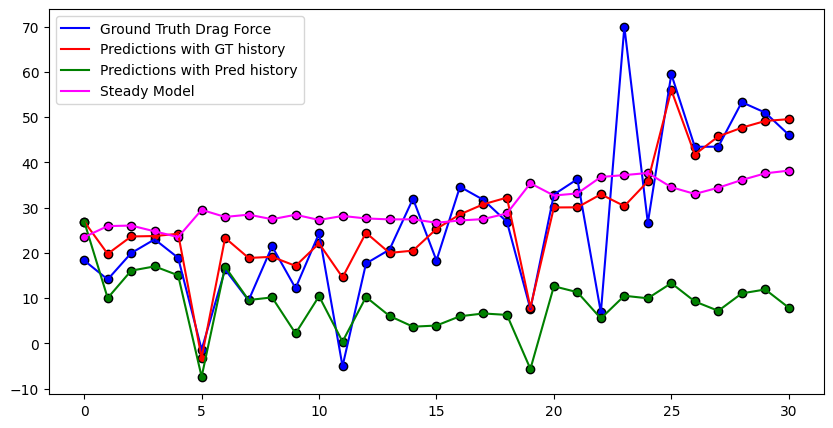

In [60]:
plt.figure(figsize=(10,5))

plt.plot(np.arange(len(gt_new)),gt_new,c="blue")

plt.plot(np.arange(len(pred_new)),pred_new,c="red")

plt.plot(np.arange(len(pred_reccurence)),pred_reccurence,c="green")

plt.plot(np.arange(len(pred_steady)),pred_steady,c="magenta")

plt.scatter(np.arange(len(gt_new)),gt_new,c="blue",edgecolor="black")
plt.scatter(np.arange(len(pred_new)),pred_new,c="red",edgecolor="black")
plt.scatter(np.arange(len(pred_reccurence)),pred_reccurence,c="green",edgecolor="black")
plt.scatter(np.arange(len(pred_steady)),pred_steady,c="magenta",edgecolor="black")

plt.legend(["Ground Truth Drag Force","Predictions with GT history"
           ,"Predictions with Pred history","Steady Model"])

In [61]:
### min max drag forces (-103.509113, 110.135844) ###

# Comparing the methods rho2 30percent Re300

In [ ]:
train_unsteady = np.load("simple_connections_data/temporal_split/rho2_30percent_Re300/epoch_loss_train.npy")
test_unsteady = np.load("simple_connections_data/temporal_split/rho2_30percent_Re300/epoch_loss_test.npy")

train_steady = np.load("../ze_testing_procedure/extrapolation/rho2_30percent_Re300/80_20_time_split/results_trial_1/epoch_loss_train.npy")
test_steady = np.load("../ze_testing_procedure/extrapolation/rho2_30percent_Re300/80_20_time_split/results_trial_1/epoch_loss_val.npy")

plt.semilogy(train_steady)
plt.semilogy(test_steady,'--')

plt.semilogy(train_unsteady)
plt.semilogy(test_unsteady,'--')

plt.legend(["Train Steady","Test Steady","Train Unsteady","Test Unsteady"])

In [ ]:
unsteady_gnn =  pd.read_csv("/home/neilashwinraj/gnns/volatile/attention_GNN_with_transformers")
steady_gnn =  pd.read_csv("/home/neilashwinraj/gnns/volatile/GNN_simple_connections_no_attention")
xgboost =  pd.read_csv("/home/neilashwinraj/gnns/volatile/XGBoost")

count, bins_count_unsteady_gnn = np.histogram(unsteady_gnn["Rel Err"], bins=2000) 
pdf = count / sum(count) 
cdf_unsteady_gnn = np.cumsum(pdf)

plt.semilogx(bins_count_unsteady_gnn[1:],cdf_unsteady_gnn)

count, bins_count_steady_gnn = np.histogram(steady_gnn["Rel Err"], bins=2000) 
pdf = count / sum(count) 
cdf_steady_gnn = np.cumsum(pdf) 

plt.semilogx(bins_count_steady_gnn[1:],cdf_steady_gnn)


count, bins_count_xgboost = np.histogram(xgboost["Rel Err"], bins=2000) 
pdf = count / sum(count) 
cdf_xgboost = np.cumsum(pdf) 

plt.semilogx(bins_count_xgboost[1:],cdf_xgboost)
plt.legend(["unsteady gnn","steady gnn","XGBoost"])

plt.xlim([0.02,5])
# plt.ylim([0.2,0.4])

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(20,3))

axs[0].set_title("Unsteady GNN")
axs[0].plot(np.linspace(-100,200,150),np.linspace(-100,200,150),c="black")
axs[0].scatter(unsteady_gnn["GT Drag"].values,unsteady_gnn["Pred Drag"].values,c="blue",alpha=0.5)
axs[0].text(-90, 190, f'R² = {r2_score(unsteady_gnn["GT Drag"].values,unsteady_gnn["Pred Drag"].values):.2f}', fontsize=12)

axs[1].set_title("Steady GNN")
axs[1].plot(np.linspace(-100,200,150),np.linspace(-100,200,150),c="black")
axs[1].scatter(steady_gnn["GT Drag"].values,steady_gnn["Pred Drag"].values,c="blue",alpha=0.5)
axs[1].text(-90, 190, f'R² = {r2_score(steady_gnn["GT Drag"].values,steady_gnn["Pred Drag"].values):.2f}', fontsize=12)

axs[2].set_title("XGBoost")
axs[2].plot(np.linspace(-100,200,150),np.linspace(-100,200,150),c="black")
axs[2].scatter(xgboost["GT Drag"].values,xgboost["Pred Drag"].values,c="blue",alpha=0.5)
axs[2].text(-90, 190, f'R² = {r2_score(xgboost["GT Drag"].values,xgboost["Pred Drag"].values):.2f}', fontsize=12)

In [ ]:
len(unsteady_gnn)

In [ ]:
### verify ###
for i in range(len(unsteady_gnn)):
    print("Datapoint number : ",str(i+1))
    decision = steady_gnn[steady_gnn["GT Drag"]==unsteady_gnn.iloc[i]["GT Drag"]]
    
    if decision.empty:
        print("Error")
        break
    
#     clear_output(wait=True)
    
print(len(unsteady_gnn))